## Lab 1 - Overview of embeddings-based retrieval

In [ ]:
%%capture
%%bash

pip install -q langchain pypdf chromadb sentence_transformers google-generativeai umap-learn backoff

In [ ]:
filename = 'cisco-annual-report-2023.pdf'
!curl -s -o {filename} https://www.cisco.com/c/dam/en_us/about/annual-report/{filename}

In [ ]:
from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd
import google.generativeai as genai
from IPython.display import display, Markdown
import umap
import numpy as np

from functools import lru_cache
import backoff

In [ ]:
def md(text): display(Markdown(text))

In [ ]:
reader = PdfReader(filename)
texts = [page.extract_text().strip() for page in reader.pages]

# filter out empty strings
texts = [text for text in texts if text]

In [ ]:
texts[0]

'2023 Annual ReportCreating \na world of \npotential'

In [ ]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(texts))

print(character_split_texts[0][:500], "\n")
print("Total chunks", len(character_split_texts))

2023 Annual ReportCreating 
a world of 
potential

Cisco (Nasdaq: CSCO) is the worldwide leader 
in technology that powers the internet. 
Discover more at thenetwork.cisco.com and 
follow us on X at @CiscoAbout
Cisco
Our strategy
We securely connect everything to make anything possible
Our differentiation  
Innovation
Customer outcomes at 
massive scale
 ●Market-leading secure networking
 ●Integrated solutions across broad 
portfolio
 ●Unmatched, AI-driven insights
 ●400B security events observe 

Total chunks 614


In [ ]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in tqdm(character_split_texts):
  token_split_texts += token_splitter.split_text(text)

print("\n")
print(token_split_texts[0][:500], "\n")
print("Total chunks", len(token_split_texts))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

100%|██████████| 614/614 [00:03<00:00, 179.83it/s]



2023 annual reportcreating a world of potential cisco ( nasdaq : csco ) is the worldwide leader in technology that powers the internet. discover more at thenetwork. cisco. com and follow us on x at @ ciscoabout cisco our strategy we securely connect everything to make anything possible our differentiation innovation customer outcomes at massive scale ●market - leading secure networking ●integrated solutions across broad portfolio ●unmatched, ai - driven insights ●400b security events observed pe 

Total chunks 666


In [ ]:
embedding_function = SentenceTransformerEmbeddingFunction()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# chroma_client = chromadb.Client()
chroma_client = chromadb.PersistentClient(path="db/")

In [ ]:
chroma_collection_name = Path(filename).stem
chroma_collection = chroma_client.create_collection(chroma_collection_name, embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)

print("Total indexed documents", chroma_collection.count())

Total indexed documents 666


In [ ]:
%env GOOGLE_API_KEY=

env: GOOGLE_API_KEY=


In [ ]:
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])

In [ ]:
@lru_cache(maxsize=128)
def rag(query, topk=5, model='models/chat-bison-001'):
  # retrive relevent documents
  results = chroma_collection.query(query_texts=[query], n_results=topk)
  retrieved_documents = results['documents'][0]
  # construct prompt
  context = """
You are a helpful expert financial research assistant.
Your users are asking questions about information contained in an annual report.

You will be shown the user's question, and the relevant information from the annual report.
Answer the user's question using only this information.
"""
  messages = []
  information = '\n\n'.join(retrieved_documents)
  messages.append({'author': '0', 'content': f"Question: {query}. \n Information: {information}"})
  # generate answer
  response = genai.chat(
    model=model,
    context=context,
    messages=messages,
    temperature=0,
    candidate_count=2
    )
  answer = response.last
  return answer

In [ ]:
answer = rag("What was the total revenue?")
md(f'```\n{answer}\n```')

```
The total revenue for the company in 2023 was $43,142 million. This is an increase of 13% from the total revenue of $38,018 million in 2022. The increase in revenue was driven by growth in both product and service revenue. Product revenue increased by 11%, while service revenue increased by 15%. The company's operating income was $2,030 million in 2023, an increase of 28% from the operating income of $1,600 million in 2022. The increase in operating income was driven by the growth in revenue and the company's continued focus on cost control. The company's net income was $1,400 million in 2023, an increase of 33% from the net income of $1,050 million in 2022. The increase in net income was driven by the growth in operating income and the company's lower tax rate.
```

In [ ]:
@backoff.on_exception(backoff.expo, (InternalServerError, TooManyRequests))
def palm(prompt, name='models/text-bison-001'):
  response = genai.generate_text(
    model=name,
    prompt=prompt,
    temperature=0,
    candidate_count=2
    )
  answer = response.candidates[0]['output']
  return answer

@backoff.on_exception(backoff.expo, (InternalServerError, TooManyRequests))
def gemini(prompt, name='gemini-pro'):
  model = genai.GenerativeModel(name)
  response = model.generate_content(prompt)
  answer = response.text
  return answer

In [ ]:
@lru_cache(maxsize=128)
def rag(model, query, topk=5):
  # retrive relevent documents
  results = chroma_collection.query(query_texts=[query], n_results=topk)
  retrieved_documents = results['documents'][0]
  information = '\n\n'.join(retrieved_documents)
  # construct prompt
  prompt = f"""
You are a helpful expert financial research assistant.
Your users are asking questions about information contained in an annual report.

You will be shown the user's question, and the relevant information from the annual report.
Answer the user's question using only this information.

Information: {information}

Question: {query}
"""
  # generate answer
  answer = model(prompt)
  return answer

In [ ]:
answer = rag(palm, "What was the total revenue?")
md(f'```\npalm: {answer}\n```')
answer = rag(gemini, "What was the total revenue?")
md(f'```\ngemini: {answer}\n```')

```
palm: The total revenue was $43,142.
```

```
gemini: $43,142
```

In [ ]:
answer = rag(palm, "What was the revenue per business unit?")
md(f'```\npalm: {answer}\n```')
answer = rag(gemini, "What was the revenue per business unit?")
md(f'```\ngemini: {answer}\n```')

```
palm: The revenue per business unit was $8,427 for the Americas, $3,269 for EMEA, and $2,160 for APJC.
```

```
gemini: Unfortunately, the text provided does not contain information about revenue per business unit.
```

In [ ]:
response = rag(palm, "What do you think of this finantial report?")
md(f'```\n{response}\n```')

```
The financial report is well-presented and easy to understand. It provides a comprehensive overview of Cisco's financial performance, including its revenue, expenses, and net income. The report also provides information on Cisco's debt, cash flow, and shareholders' equity. Overall, the financial report provides a good picture of Cisco's financial health.
```

In [ ]:
response = rag(palm, "How does the growth for next year looks like?")
md(f'```\n{response}\n```')

```
Cisco expects revenue growth of 4% in fiscal 2024.
```

## Lab2: Pitfalls of retrieval - when simple vector search fails!

In [ ]:
chroma_collection = chroma_client.get_or_create_collection(chroma_collection_name)

In [ ]:
documents = chroma_collection.get(include=['embeddings'])
embeddings = documents['embeddings']

In [ ]:
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
def project_embeddings(embeddings, umap_transform):
  umap_embeddings = np.empty((len(embeddings), 2))
  for i, embedding in enumerate(tqdm(embeddings)):
    umap_embeddings[i] = umap_transform.transform([embedding])
  return umap_embeddings

In [ ]:
projected_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 666/666 [12:18<00:00,  1.11s/it]


In [ ]:
np.save('umap_embeddings.npy', projected_embeddings)
projected_dataset_embeddings = np.load('umap_embeddings.npy')

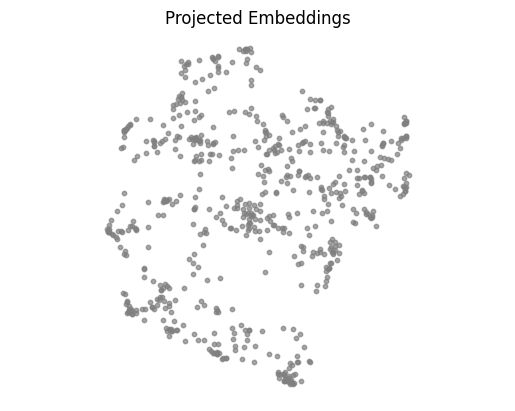

In [ ]:
import matplotlib.pyplot as plt

x, y = projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1]

plt.figure()
plt.scatter(x, y, s=10, color='gray', alpha=0.7)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')
plt.show()

In [ ]:
def plot(projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings):
  plt.figure()
  p1 = plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray', alpha=0.7)
  p2 = plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=100, marker='x', color='r')
  p3 = plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=80, facecolors='none', edgecolors='g')
  plt.legend((p1, p2, p3),
           ('Dataset document', 'User Query', 'Retrieved document'),
           scatterpoints=1, fontsize=8)
  plt.gca().set_aspect('equal', 'datalim')
  plt.title(query)
  plt.axis('off')
  plt.show()

def plot_projected_embeddings(query):
  # embed query
  query_embedding = embedding_function([query])[0]
  # retrieve embeddings of relevent documents
  results = chroma_collection.query(query_texts=[query], n_results=5, include=['embeddings'])
  retrieved_embeddings = results['embeddings'][0]
  # project embeddings using UMAP
  projected_query_embedding = project_embeddings([query_embedding], umap_transform)
  projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)
  # plot the projected query and retrieved documents in the embedding space
  plot(projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings)


/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 29.3MiB/s]
100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


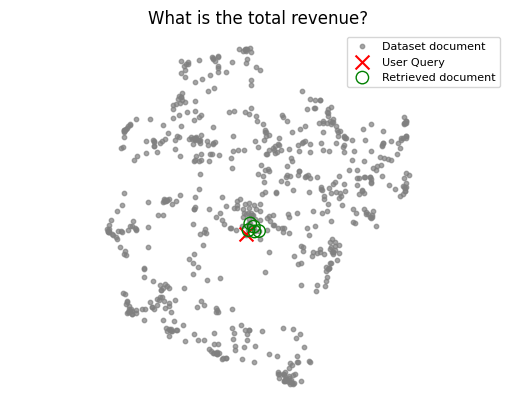

In [ ]:
query = "What is the total revenue?"

plot_projected_embeddings(query)

100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


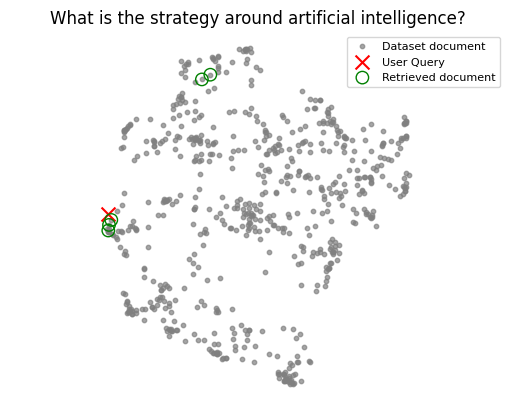

In [ ]:
query = "What is the strategy around artificial intelligence?"

plot_projected_embeddings(query)

100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


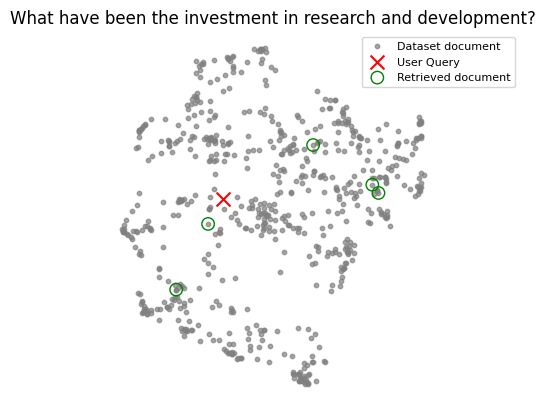

In [ ]:
query = "What have been the investment in research and development?"

plot_projected_embeddings(query)

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


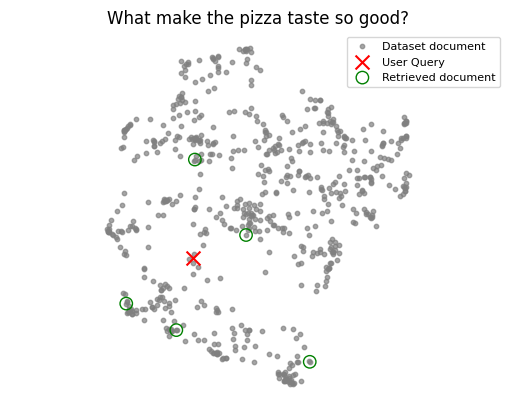

In [ ]:
query = "What make the pizza taste so good?"

plot_projected_embeddings(query)

## Lab 3: Query Expansion

### Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [ ]:
@lru_cache(maxsize=128)
def augment_query_generated(query, model='models/chat-bison-001'):
  # construct prompt
  context = """
You are a helpful expert financial research assistant.
Provide an example answer to the given question, that might be found in a document like an annual report.
"""
  messages = []
  messages.append({'author': '0', 'content': query})
  # generate answer
  response = genai.chat(
    model=model,
    context=context,
    messages=messages,
    temperature=0,
    candidate_count=2
    )
  answer = response.last
  return answer

In [ ]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
md(f'```\n{joint_query}\n```')

```
Was there significant turnover in the executive team? There was no significant turnover in the executive team in the past year. The company's CEO, CFO, and COO have all been with the company for more than 5 years. The company's CMO and CIO have been with the company for more than 3 years. The company's executive team is experienced and stable, which provides continuity and stability for the company.

The company's executive team is responsible for the company's overall strategy and direction. They are also responsible for the company's financial performance and operations. The company's executive team is a group of highly skilled and experienced professionals who are committed to the company's success.

The company's executive team is led by the CEO, who is responsible for the company's overall performance. The CFO is responsible for the company's financial performance. The COO is responsible for the company's operations. The CMO is responsible for the company's marketing and sales. The CIO is responsible for the company's information technology.

The company's executive team is a valuable asset to the company. They are a group of highly skilled and experienced professionals who are committed to the company's success.
```

In [ ]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for idx, doc in enumerate(retrieved_documents, start=1):
    print(f'{idx}.', doc)
    print('')

1. corporate governance leadership 12 financial experience 11 global business 11public company board experience 10 gender / ethnic / racial / sexual orientation diversity 6 42 % women 58 % men 83 % white 8 % african american or black and native american 8 % asian 17 % lgbtq + 11 independent 1 non - independent 7 director 0 - 5 years 1 director 6 - 8 years 4 director 9 + yearsthe role of the board of directors in strategy one of the board ’ s key responsibilities is overseeing management ’ s formulation and execution of cisco ’ s strategy. throughout the year, our ceo, the executive leadership team, and other leaders from across the company provide detailed business and strategy updates to the board. during these reviews, the board engages with the executive leadership team and other business leaders regarding various topics, including business strategy and initiatives, capital allocation, portfolio updates, the competitive landscape, talent and culture ( including inclusion

2. corpora

In [ ]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


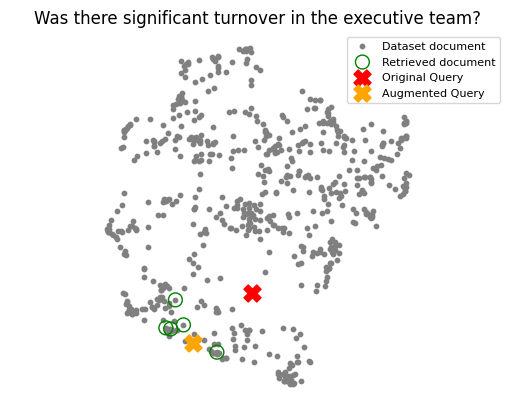

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
p1 = plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
p2 = plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
p3 = plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
p4 = plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')
plt.legend((p1, p2, p3, p4),
           ('Dataset document', 'Retrieved document', 'Original Query', 'Augmented Query'),
           scatterpoints=1, fontsize=8)
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')
plt.show()

### Expansion with multiple queries


In [ ]:
@lru_cache(maxsize=128)
def augment_multiple_query_chat(query, model='models/chat-bison-001'):
  # construct prompt
  context = """
You are a helpful expert financial research assistant. Your users are asking questions about an annual financial report.

Given the user question, suggest up to five additional related questions to help them find the information they need.
The questions should be short without compound sentences and cover different aspects of the topic.
Make sure the questions are complete, and that they are related to the original user question.

"""
  messages = []
  messages.append({'author': '0', 'content': f'Question: {query}'})
  # generate answer
  response = genai.chat(
    model=model,
    context=context,
    messages=messages,
    temperature=0,
    candidate_count=2
    )
  questions = response.last.split("\n")
  return questions

In [ ]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query_chat(original_query)

for query in augmented_queries:
    print(query)

Here are five additional related questions that may help you find the information you need:

1. What were the company's top-selling products or services in the past year?
2. Did the company launch any new products or services in the past year?
3. Did the company expand into new markets in the past year?
4. Did the company experience any changes in its pricing or marketing strategies in the past year?
5. Did the company experience any changes in its cost structure in the past year?

By answering these questions, you can get a better understanding of the factors that contributed to the company's revenue growth.


In [ ]:
@lru_cache(maxsize=128)
def augment_multiple_query(query, model='models/text-bison-001'):
  # construct prompt
  prompt = f"""
You are a helpful expert financial research assistant. Your users are asking questions about an annual financial report.

Given the user question, suggest up to five additional related questions to help them find the information they need.
The questions should be short without compound sentences and cover different aspects of the topic.
Make sure the questions are complete, and that they are related to the original user question.

Output one question per line. Do not number the questions.

Question: {query}
"""

  # generate answer
  response = genai.generate_text(
    model=model,
    prompt=prompt,
    temperature=0,
    candidate_count=2
    )
  questions = response.candidates[0]['output'].split("\n")
  return questions

In [ ]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

How did the company's revenue compare to the previous year?
What were the company's top-selling products or services?
What were the company's main sources of revenue?
How did the company's revenue growth compare to its competitors?


In [ ]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for idx, doc in enumerate(documents, start=1):
        print(f'{idx}.', doc)
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
1. products. this was partially offset by negative impacts from productivity, largely driven by increased costs from component and other

2. apjc................................... 8, 417 8, 027 7, 706 390 5 % percentage of revenue..................... 14. 8 % 15. 6 % 15. 5 % total................................ $ 56, 998 $ 51, 557 $ 49, 818 $ 5, 441 11 % amounts may not sum and percentages may not recalculate due to rounding. total revenue in fiscal 2023 increased by 11 % compared with fiscal 2022. product revenue increased by 13 % and service revenue increased by 2 %. our total revenue reflected growth across each of our geographic segments. in addition to the impact of macroeconomic factors, including the it spending environment and the level of spending by government entities, revenue by segment in a particular period may be significantly impacted by the timing of revenue recognition fo

In [ ]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embeddings = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


In [ ]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_retrieved_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


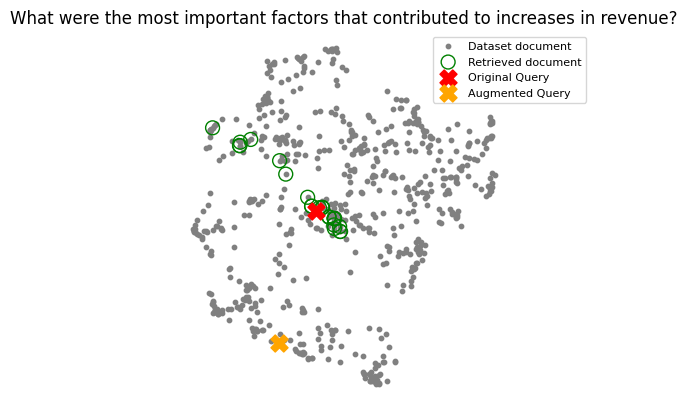

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
p1 = plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
p2 = plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
p3 = plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
p4 = plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')
plt.legend((p1, p2, p3, p4),
           ('Dataset document', 'Retrieved document', 'Original Query', 'Augmented Query'),
           scatterpoints=1, fontsize=8)
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')
plt.show()

## Lab 4 - Cross-encoder re-ranking

### Re-ranking the long tail

In [ ]:
query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for idx, document in enumerate(results['documents'][0], start=1):
    print(f'{idx}.', document)
    print('')

1. investments, some of which may be based on the achievement of certain agreed - upon milestones or are required to be funded on demand the carrying value of these investments and the additional funding commitments, collectively, represent our maximum exposure related to privately held investments

2. 9research and development we regularly introduce new products and features to address the requirements of our markets. we allocate our research and development budget among our product categories, which consist of secure, agile networks ; internet for the future ; collaboration ; end - to - end security ; optimized application experiences ; and other product technologies. our research and development expenditures are applied generally to all product areas, with specific areas of focus being identified from time to time. our expenditures for research and development costs were expensed as incurred. the industry in which we compete is subject to rapid technological developments, evolving s

In [ ]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)

In [ ]:
new_order = np.argsort(scores)[::-1]

pd.DataFrame({'Document': retrieved_documents, 'Score': scores, 'New Ordering': new_order})

,Document,Score,New Ordering
0,"investments, some of which may be based on the...",-5.370131,1
1,9research and development we regularly introdu...,-1.060988,9
2,a changing climate by investing in regenerativ...,-7.489060,8
3,"capitalized research expenditures 2, 042 149 o...",-9.361263,0
4,early stages and may never materialize. we cou...,-6.565883,5
5,.................................................,-6.531519,4
6,22entrance into new or developing markets expo...,-9.782705,7
7,priority and growth areas. we also intend to f...,-7.122745,2
8,"43research and development ( “ r & d ” ), sale...",-5.182986,3
9,to other market transitions — such as security...,-5.107238,6


### Re-ranking with Query Expansion

In [ ]:
original_query = "What were the most important factors that contributed to increases in revenue?"
generated_queries = [
    "What were the major drivers of revenue growth?",
    "Were there any new product launches that contributed to the increase in revenue?",
    "Did any changes in pricing or promotions impact the revenue growth?",
    "What were the key market trends that facilitated the increase in revenue?",
    "Did any acquisitions or partnerships contribute to the revenue growth?"
]

In [ ]:
queries = [original_query] + generated_queries

results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [ ]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

In [ ]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [ ]:
scores = cross_encoder.predict(pairs)

In [ ]:
new_order = np.argsort(scores)[::-1]

pd.DataFrame({'Document': unique_documents, 'Scores': scores, 'New Ordering': new_order})

,Document,Scores,New Ordering
0,percentage of revenue..................... 24....,-9.003052,14
1,"emea................................. 15, 135 ...",-7.266654,20
2,tax rate for future periods is uncertain and c...,-10.307104,10
3,products. this was partially offset by negativ...,-6.744735,13
4,"apjc................................... 8, 417...",-4.381598,17
5,"proceeds from maturities of investments 5, 978...",-11.128781,23
6,", 101 2, 152 377 18 % percentage of revenue......",-8.027184,12
7,714. acquisitions and divestitures ( a ) acqui...,-11.128980,21
8,"and sporadic purchases, and the revenue relate...",-5.321942,4
9,"43research and development ( “ r & d ” ), sale...",-9.735474,24


## Lab 5 - Embedding Adaptors

### Creating a dataset

In [ ]:
def generate_queries(model):
  # construct prompt
  prompt = """
You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies.
Suggest 10 to 15 short questions that are important to ask when analyzing an annual report.
Do not output any compound questions (questions with multiple sentences or conjunctions).

Output one question per line. Do not number the questions.
"""
  # generate answer
  questions = model(prompt)
  questions = questions.split("\n")
  return questions

In [ ]:
generated_queries = generate_queries(palm)
for query in generated_queries:
    print(query)

* What are the company's revenue and profit margins?
* How much debt does the company have?
* What is the company's cash flow?
* What are the company's earnings per share (EPS)?
* What is the company's dividend yield?
* What is the company's price-to-earnings (P/E) ratio?
* What is the company's debt-to-equity ratio?
* What is the company's return on equity (ROE)?
* What is the company's return on assets (ROA)?
* What is the company's growth rate?
* What are the company's prospects for the future?
* What are the risks associated with investing in the company?


In [ ]:
generated_queries = generate_queries(gemini)
for query in generated_queries:
    print(query)

* What is the company's revenue growth rate?
* What is the company's profit margin?
* What is the company's debt-to-equity ratio?
* What is the company's cash flow from operations?
* What is the company's return on equity?
* What is the company's dividend yield?
* What is the company's book value per share?
* What is the company's price-to-earnings ratio?
* What is the company's price-to-sales ratio?
* What is the company's price-to-book ratio?
* What is the company's analyst rating?
* What are the company's future growth prospects?
* What are the company's key risks?
* What is the company's competitive advantage?
* What is the company's management team like?


In [ ]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [ ]:
@lru_cache(maxsize=128)
def evaluate_results(model, query, statement):
  # construct prompt
  prompt = f"""
You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies.
For the given query, evaluate whether the following satement is relevant.
Output only 'yes' or 'no'.

Query: {query}, Statement: {statement}'
"""
  # generate answer
  answer = model(prompt)
  if answer == "yes":
    return 1
  return -1

In [ ]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [ ]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [ ]:
for q, query in enumerate(tqdm(generated_queries)):
  for d, document in enumerate(retrieved_documents[q]):
    adapter_query_embeddings.append(query_embeddings[q])
    adapter_doc_embeddings.append(retrieved_embeddings[q][d])
    adapter_labels.append(evaluate_results(palm, query, document))

100%|██████████| 15/15 [02:37<00:00, 10.51s/it]


In [ ]:
len(adapter_labels)

150

In [ ]:
import torch
from torch.utils.data import TensorDataset

In [ ]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [ ]:
dataset = TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

### Setting up the model

In [ ]:
def model(query_embedding, document_embedding, weights):
  projected_query_embedding = torch.matmul(weights, query_embedding)
  predictions = torch.cosine_similarity(projected_query_embedding, document_embedding, dim=0)
  return predictions

In [ ]:
def mse_loss(predictions, labels):
  return torch.nn.MSELoss()(predictions, labels)

Initialize Adoptor Matrix

In [ ]:
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [ ]:
epochs = 100
lr = 0.01
min_loss = float('inf')
best_matrix = None
loss_history = []

for epoch in tqdm(range(epochs)):
  for query_embedding, document_embedding, label in dataset:
    prediction = model(query_embedding, document_embedding, adapter_matrix)
    loss = mse_loss(prediction, label)
    loss.backward()
    loss = loss.detach().numpy()
    loss_history.append(loss)

    if loss < min_loss:
      min_loss = loss
      best_matrix = adapter_matrix.clone().detach().numpy()

    with torch.no_grad():
      adapter_matrix -= lr * adapter_matrix.grad
      adapter_matrix.grad.zero_()

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


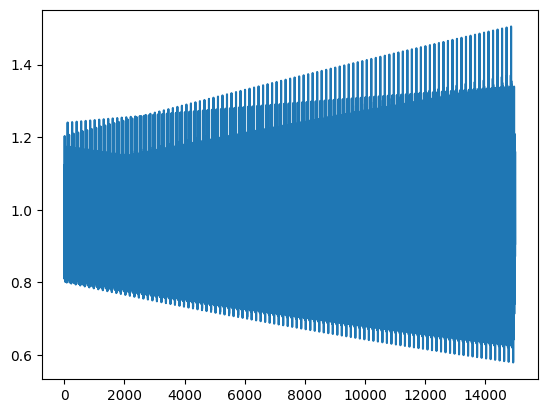

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
print(f"Best loss: {min_loss}")

Best loss: 0.5793995261192322


In [ ]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

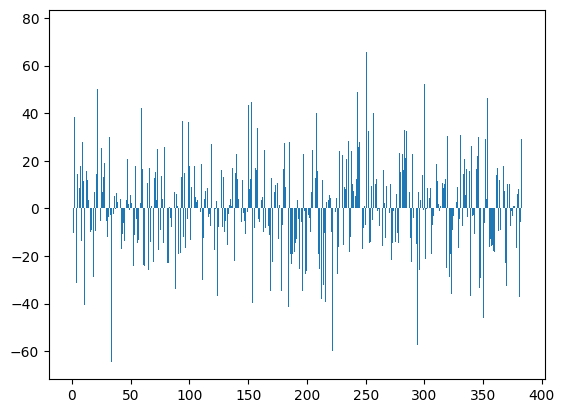

In [ ]:
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [ ]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Plot the projected query and retrieved documents in the embedding space

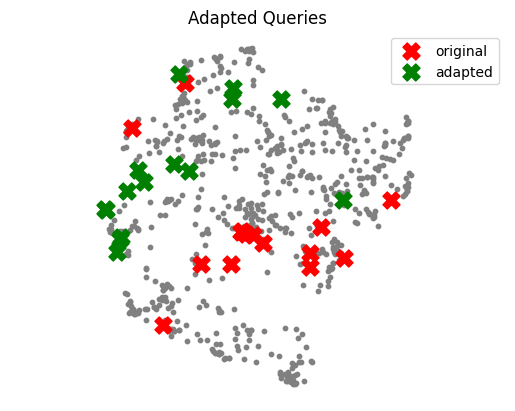

In [ ]:
plt.figure()
p1 = plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
p2 = plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
p3 = plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")
plt.legend((p1, p2, p3),
          ('Dataset document', 'User Query', 'Adapted query'),
          scatterpoints=1, fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()
plt.show()